# DATA 준비

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.compat.v1 as tf

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

shift_days  = 3
hoursteps   = 24
timesteps   = shift_days*hoursteps #hours step
data_dim    = 4
out_dim     = 1

##############################################
#  Load data, Normalization
##############################################
df_weather = read_csv('../DATA/weather.csv', header=0, index_col=0)
df_pow     = read_csv('../DATA/pow.csv')
pow_set    = df_pow.values
df_weather.insert(0,'pow',pow_set)          #pow_X + weather
df_weather = df_weather.iloc[:, 0:data_dim] #feature size 조절

# normalization
df_weather = df_weather.astype('float32')
df_weather = df_weather.interpolate(method='linear')


#df_weather = df_weather.iloc[0:100, :] #feature size 조절
df_weather.to_csv("../data/total.csv",mode='w',index=False)
print(df_weather.head(5))

#Scaler
robustScaler = RobustScaler()
print(robustScaler.fit(df_weather))
df_scaled = pd.DataFrame(robustScaler.transform(df_weather), columns=df_weather.columns)
df_scaled.to_csv("../data/scaled.csv",mode='w',index=False, header=False)
#robustScaler.inverse_transform()

#pow_Y insert
df_powY = df_pow['pow'].shift(-timesteps) #pow_Y : time step만큼 shift
df_weather.insert(df_weather.shape[1], 'pow_Y',df_powY.values)
'''
maxAbsScaler = MaxAbsScaler()
print(maxAbsScaler.fit(df_weather))
scaled_dataset = pd.DataFrame(maxAbsScaler.transform(df_weather), columns=df_weather.columns)
scaled_dataset.to_csv("../data/scaled.csv",mode='w',index=False, header=False)
'''
'''
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = pd.DataFrame(scaler.fit_transform(df_weather), columns=df_weather.columns)
scaled_dataset.to_csv("../data/scaled.csv",mode='w',index=False, header=False)
'''

                  pow  sunshine  grd_temprt  humdt
ymdhms                                            
2019-08-20 00:00  0.0       0.0   23.100000   99.0
2019-08-20 01:00  0.0       0.0   22.900000   98.0
2019-08-20 02:00  0.0       0.0   22.200001   99.0
2019-08-20 03:00  0.0       0.0   21.600000   99.0
2019-08-20 04:00  0.0       0.0   21.200001   99.0
RobustScaler()


'\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_dataset = pd.DataFrame(scaler.fit_transform(df_weather), columns=df_weather.columns)\nscaled_dataset.to_csv("../data/scaled.csv",mode=\'w\',index=False, header=False)\n'

c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

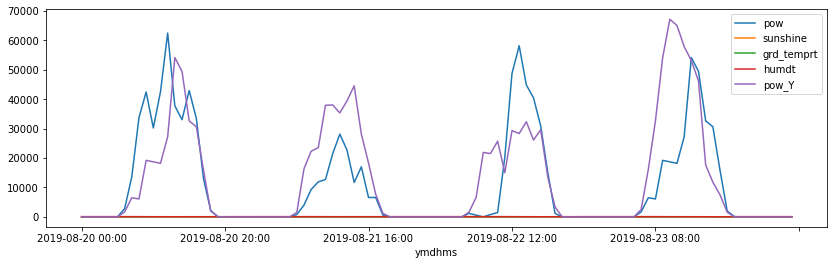

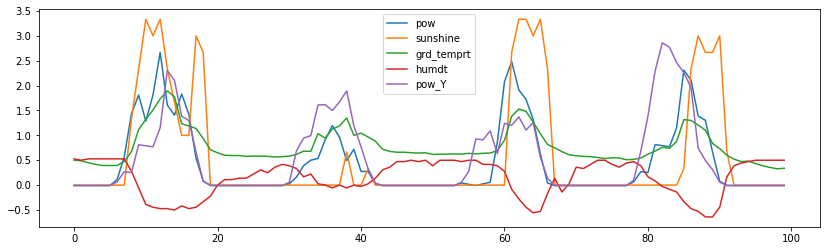

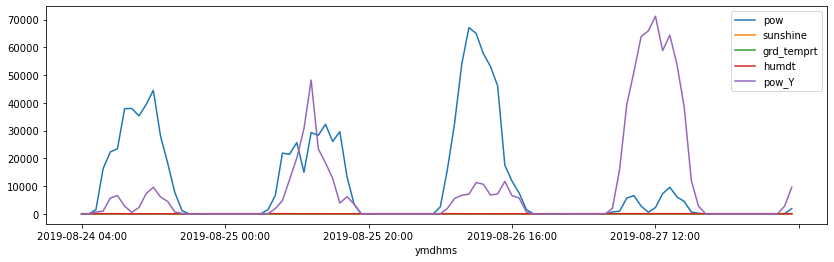

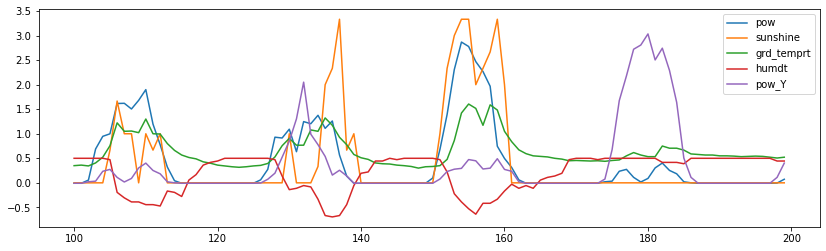

In [45]:
plt.rcParams["figure.figsize"] = (14,4)
df_weather.iloc[0:100, :].plot()
scaled_dataset.iloc[0:100, :].plot()
df_weather.iloc[100:200, :].plot()
scaled_dataset.iloc[100:200, :].plot()

In [46]:
len_dataset = df_scaled.shape[0]
dataset = df_scaled.values #total_main
print('df_weather : ', df_weather.shape)

#################################################
# time step만큼 window 움직여 dataset 생성
#################################################
dataX, dataY = [], []
print("range : ",len_dataset-timesteps-24+1, '(=', len_dataset,'-',timesteps,'-24 )' )#=384
for i in range(0, len_dataset-timesteps-24+1, hoursteps):#hoursteps
    dataX.append(dataset[i:(i + timesteps),0:-1])
    dataY.append(dataset[i:(i + hoursteps),[-1]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

##############################################
#  Split train/test 
##############################################
print('\n------------------------ Split train/test ')

train_size = int(len(dataX) * 0.6)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size

val_idx = train_size+val_size
trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, ', Y : ', trainY.shape)
print('val   X : ', valX.shape,   ', Y : ', valY.shape)
print('test  X : ', testX.shape,  ', Y : ', testY.shape)

df_weather :  (8544, 5)
range :  8449 (= 8544 - 72 -24 )
len(dataX) :  353 (72, 3)
len(dataY) :  353 (24, 1)

------------------------ Split train/test 
train X :  (211, 72, 3) , Y :  (211, 24, 1)
val   X :  (70, 72, 3) , Y :  (70, 24, 1)
test  X :  (72, 72, 3) , Y :  (72, 24, 1)


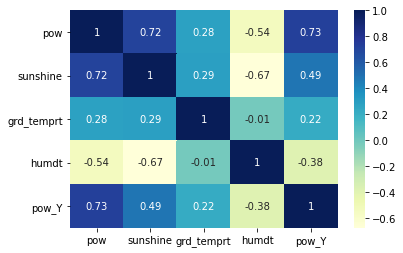

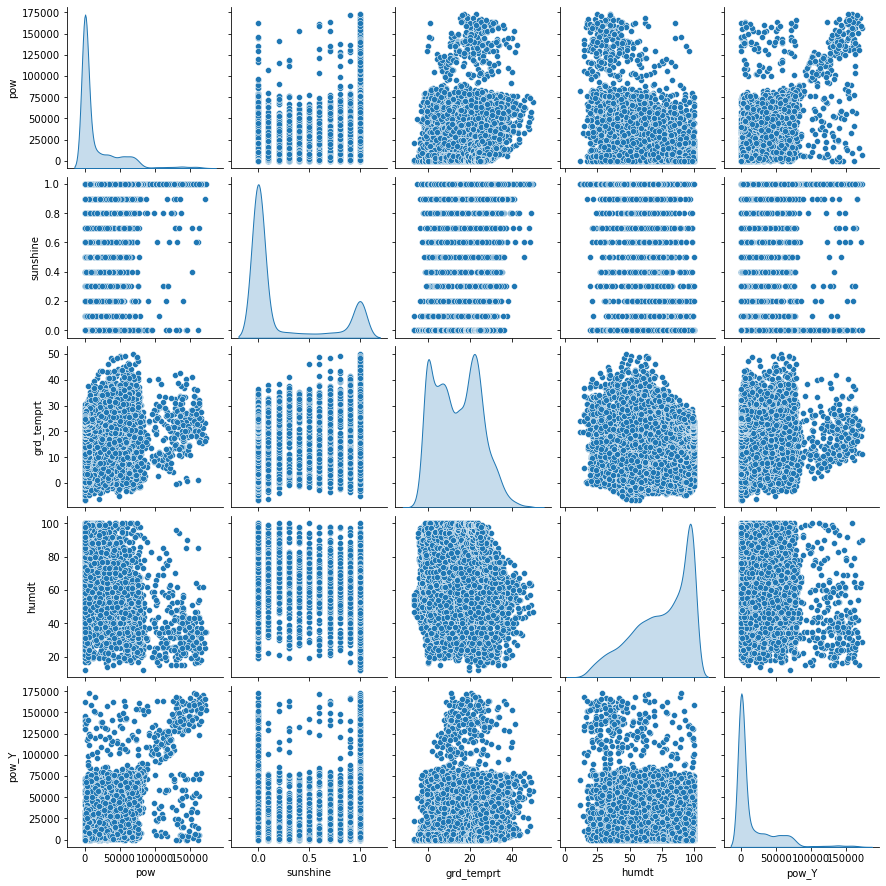

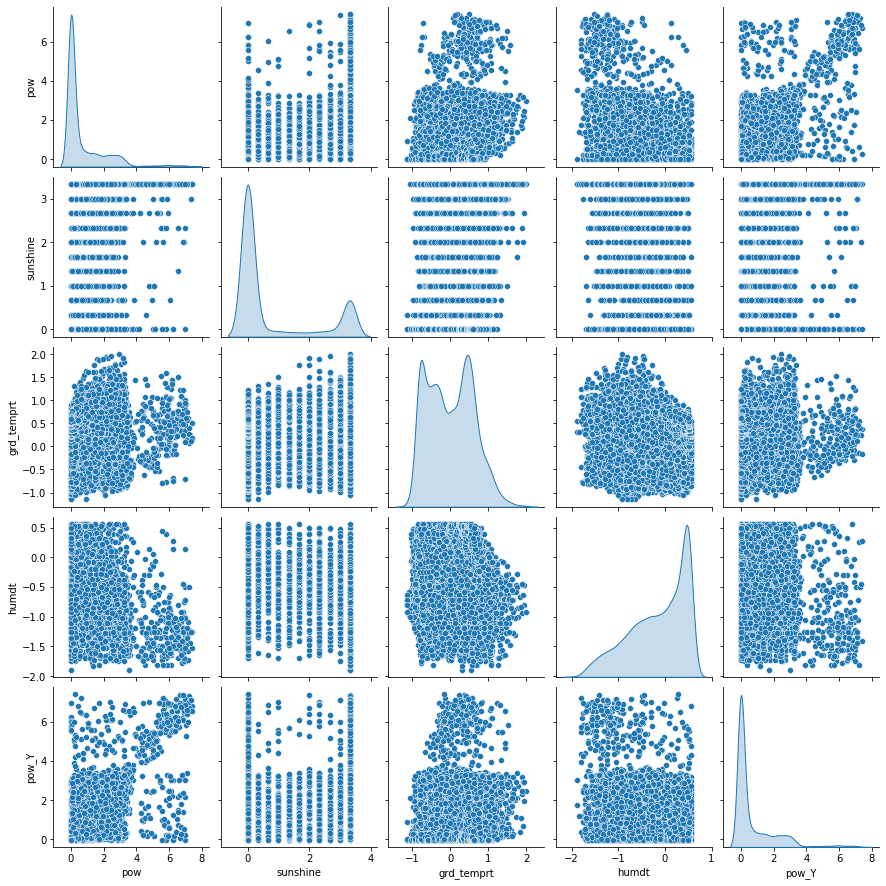

In [24]:
import seaborn as sns
sns.heatmap(df_weather.corr(), annot=True, cmap="YlGnBu")
plt.show()

sns.pairplot(df_weather, diag_kind="kde")
plt.show()

sns.pairplot(df_scaled, diag_kind="kde")
plt.show()
#sns.pairplot(df_weather, hue="species", markers=["o", "s", "D"], palette="husl")
#plt.show()

# 모델

In [47]:
from keras.layers import BatchNormalization
##############################################
#  Model 
##############################################
model = Sequential()
model.add(LSTM(timesteps, activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#model.add(Dropout(0.3))
model.add(RepeatVector(24))
model.add(LSTM(timesteps, activation='sigmoid', return_sequences=True))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(timesteps)))
model.add(TimeDistributed(Dense(1)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 72)                21888     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 24, 72)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 72)            41760     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 72)            288       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 72)            5256      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 1)             73        
Total params: 69,265
Trainable params: 69,121
Non-trainable params: 144
________________________________________________

# compile & fit

In [49]:
##############################################
#  compile & fit 
##############################################
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['acc'])

hist = model.fit(trainX, 
                 trainY, 
                 epochs=100, 
                 batch_size=72, 
                 verbose=2,
                 validation_data=(valX, valY))


results = model.evaluate(testX, testY)
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

Train on 211 samples, validate on 70 samples
Epoch 1/100
 - 1s - loss: 0.7172 - acc: 0.0087 - val_loss: 0.4862 - val_acc: 0.0095
Epoch 2/100
 - 0s - loss: 0.6670 - acc: 0.0079 - val_loss: 0.5654 - val_acc: 0.0095
Epoch 3/100
 - 0s - loss: 0.3114 - acc: 0.0111 - val_loss: 0.7339 - val_acc: 0.0095
Epoch 4/100
 - 0s - loss: 0.4394 - acc: 0.0105 - val_loss: 0.5952 - val_acc: 0.0095
Epoch 5/100
 - 0s - loss: 0.2750 - acc: 0.0107 - val_loss: 0.4940 - val_acc: 0.0095
Epoch 6/100
 - 0s - loss: 0.3477 - acc: 0.0093 - val_loss: 0.4982 - val_acc: 0.0095
Epoch 7/100
 - 0s - loss: 0.2770 - acc: 0.0107 - val_loss: 0.5608 - val_acc: 0.0095
Epoch 8/100
 - 0s - loss: 0.2815 - acc: 0.0103 - val_loss: 0.5946 - val_acc: 0.0095
Epoch 9/100
 - 0s - loss: 0.2805 - acc: 0.0105 - val_loss: 0.5538 - val_acc: 0.0095
Epoch 10/100
 - 0s - loss: 0.2587 - acc: 0.0099 - val_loss: 0.5241 - val_acc: 0.0095
Epoch 11/100
 - 0s - loss: 0.2701 - acc: 0.0101 - val_loss: 0.5481 - val_acc: 0.0095
Epoch 12/100
 - 0s - loss: 0.

Epoch 97/100
 - 0s - loss: 0.2189 - acc: 0.0126 - val_loss: 0.8080 - val_acc: 0.0095
Epoch 98/100
 - 0s - loss: 0.2180 - acc: 0.0122 - val_loss: 0.7329 - val_acc: 0.0095
Epoch 99/100
 - 0s - loss: 0.2183 - acc: 0.0124 - val_loss: 0.8093 - val_acc: 0.0095
Epoch 100/100
 - 0s - loss: 0.2177 - acc: 0.0122 - val_loss: 0.7667 - val_acc: 0.0095
72/72 [==============================] - 0s 2ms/step


# trainX 학습과정

In [5]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

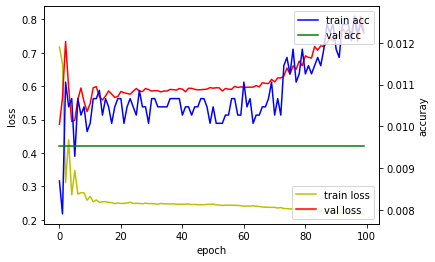

result :  [0.18433396476838323, 0.008101851679384708]


In [50]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='upper right')


plt.show()

print('result : ', results)

(5064, 1)


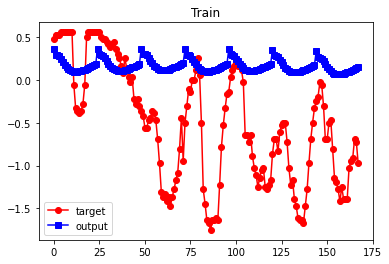

In [51]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
print(plotY.shape)
#plt.plot(plotY[-240:-72], 'ro-', label="target")
#plt.plot(plotY_pred[-240:-72], 'bs-', label="output")
end = 48
step = 168
plt.plot(plotY[-end-step:-end], 'ro-', label="target")
plt.plot(plotY_pred[-end-step:-end], 'bs-', label="output")
plt.legend()
plt.title("Train")
plt.show()

#print(plotY_pred)

(211, 24, 1)
[[0.42628568]
 [0.37130186]
 [0.3687621 ]
 [0.36054456]
 [0.33381715]
 [0.3025451 ]
 [0.27277648]
 [0.24728175]
 [0.22705813]
 [0.21217303]
 [0.20223366]
 [0.19665204]
 [0.19478624]
 [0.1960168 ]
 [0.19978116]
 [0.2055873 ]
 [0.21301647]
 [0.22171588]
 [0.2313944 ]
 [0.24181235]
 [0.25277388]
 [0.26412007]
 [0.2757221 ]
 [0.28747687]]


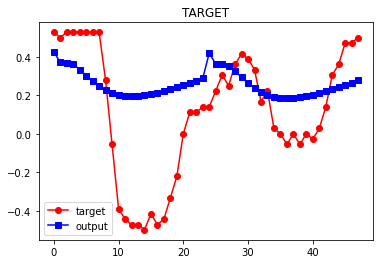

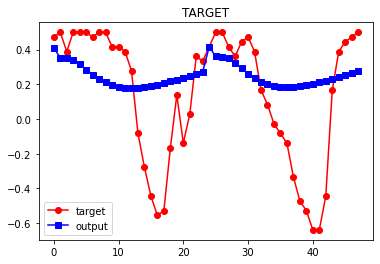

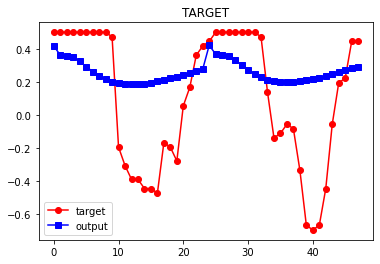

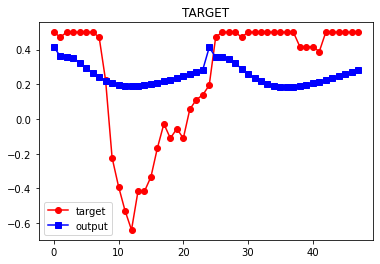

In [53]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)

print( model.predict(trainX).shape) # 211, 24

print(plotY_pred[0:24])
#plt.plot(plotY[-240:-72], 'ro-', label="target")
#plt.plot(plotY_pred[-240:-72], 'bs-', label="output")
end = 48
step = 48
#for i in range(0, plotY.shape[0]-step, step):
for i in range(0, 240-step, step):
    plt.plot(plotY[i:i+step], 'ro-', label="target")
    plt.plot(plotY_pred[i:i+step], 'bs-', label="output")
    plt.legend()
    plt.title("TARGET")
    plt.show()

#print(plotY_pred)

# testX 로 predict

In [11]:
# 예측
y_hat = model.predict(testX, batch_size=1)


'''
# 예측 결과 시각화
a_axis = np.arange(0, len(trainY))
b_axis = np.arange(len(trainY), len(trainY) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, trainY.reshape(72,), 'o-')
plt.plot(b_axis, y_hat.reshape(20,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, testY.reshape(20,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()'''

"\n# 예측 결과 시각화\na_axis = np.arange(0, len(trainY))\nb_axis = np.arange(len(trainY), len(trainY) + len(y_hat))\n\nplt.figure(figsize=(10,6))\nplt.plot(a_axis, trainY.reshape(72,), 'o-')\nplt.plot(b_axis, y_hat.reshape(20,), 'o-', color='red', label='Predicted')\nplt.plot(b_axis, testY.reshape(20,), 'o-', color='green', alpha=0.2, label='Actual')\nplt.legend()\nplt.show()"

(1800, 1)
<class 'numpy.ndarray'>
(1800, 1)


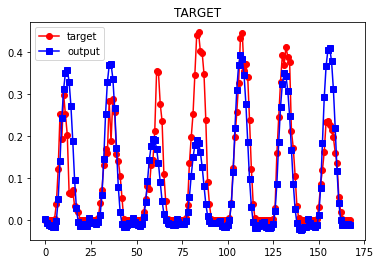

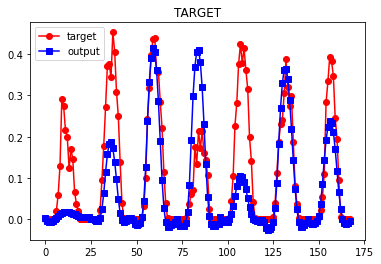

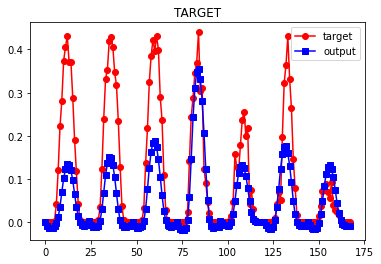

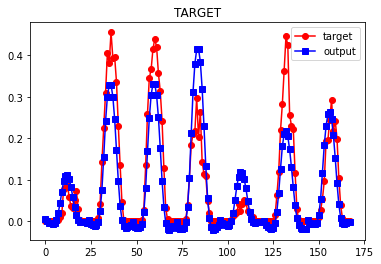

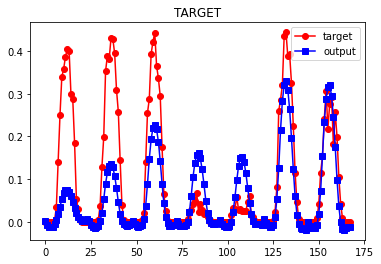

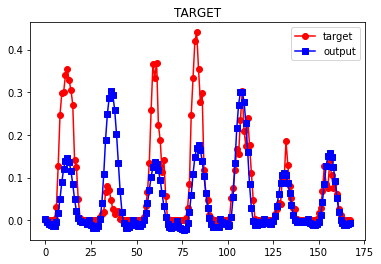

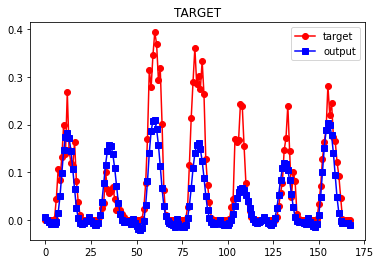

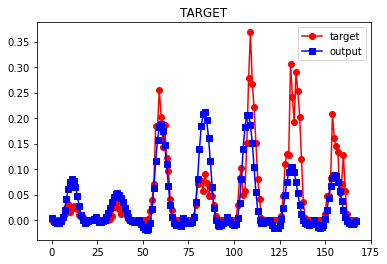

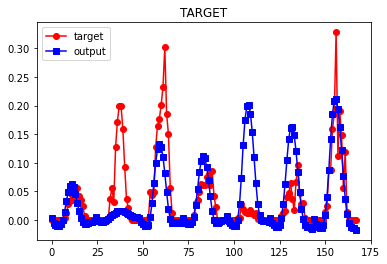

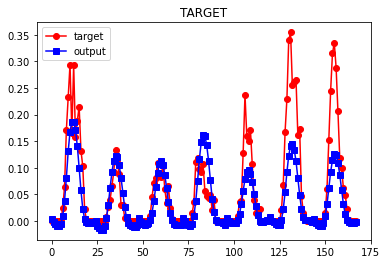

In [13]:
print(y_hat.shape)
print(type(y_hat))
y_hat.reshape(-1,1)


plotY = testY.reshape(-1,1)
y_hat = model.predict(testX).reshape(-1,1)
print(plotY.shape)
#plt.plot(plotY[-240:-72], 'ro-', label="target")
#plt.plot(plotY_pred[-240:-72], 'bs-', label="output")
end = 48
step = 168
for i in range(0, plotY.shape[0]-step, step):
    plt.plot(plotY[i:i+step], 'ro-', label="target")
    plt.plot(y_hat[i:i+step], 'bs-', label="output")
    plt.legend()
    plt.title("TARGET")
    plt.show()

#print(plotY_pred)

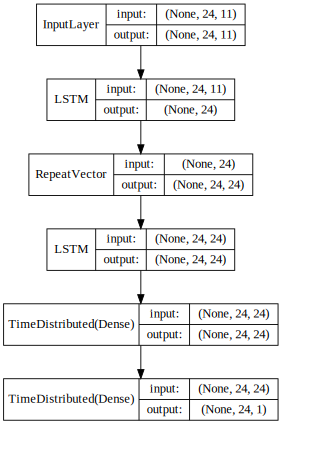

In [13]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [33]:
ex_batch = testX[0:72]
result = model.predict(ex_batch)
result

array([[[   100409.74 ],
        [    98121.48 ],
        [   281080.5  ],
        ...,
        [  -960485.9  ],
        [ -5735972.   ],
        [-12881195.   ]],

       [[  1091524.1  ],
        [  1785031.1  ],
        [  2004546.6  ],
        ...,
        [ 38591536.   ],
        [ 33032590.   ],
        [ 22590836.   ]],

       [[   110975.69 ],
        [   161657.23 ],
        [   341709.44 ],
        ...,
        [  3335366.5  ],
        [ -1019873.9  ],
        [ -7703647.   ]],

       ...,

       [[    81016.22 ],
        [   173036.53 ],
        [   296129.5  ],
        ...,
        [-17393858.   ],
        [-25128060.   ],
        [-35806090.   ]],

       [[   109744.234],
        [   184148.56 ],
        [   210496.8  ],
        ...,
        [  7826518.5  ],
        [  5415465.   ],
        [  1442521.4  ]],

       [[   168119.53 ],
        [   229100.47 ],
        [   502882.56 ],
        ...,
        [  6480578.5  ],
        [  3605700.   ],
        [ -1024730.75 ]]

In [ ]:

loss_and_metrics = model.evaluate(testX, testY, batch_size=32)
print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

# 6. 모델 사용하기
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]
yhat = model.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

In [11]:

example_result = model.predict(testX)
example_result

array([[[-0.01854459],
        [-0.0375356 ],
        [-0.04087505],
        ...,
        [-0.01368668],
        [-0.0040604 ],
        [ 0.00803049]],

       [[-0.01823278],
        [-0.03759107],
        [-0.04104709],
        ...,
        [-0.01142486],
        [-0.00323896],
        [ 0.00550799]],

       [[-0.01079173],
        [-0.02661562],
        [-0.02588986],
        ...,
        [-0.00832062],
        [ 0.00059257],
        [ 0.00790503]],

       ...,

       [[-0.00973708],
        [-0.02919267],
        [-0.04081168],
        ...,
        [ 0.02156275],
        [ 0.0017303 ],
        [-0.00127205]],

       [[-0.01144224],
        [-0.03125337],
        [-0.04326246],
        ...,
        [ 0.01479311],
        [ 0.00489809],
        [ 0.00586463]],

       [[-0.01174209],
        [-0.03122481],
        [-0.0424266 ],
        ...,
        [ 0.00589625],
        [ 0.00352197],
        [ 0.00563116]]], dtype=float32)